<a href="https://colab.research.google.com/github/economatopoeia/stock_options/blob/master/OptionsModel_8_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Options Evaluation Model: PART I



In [ ]:
###PACKAGES AND FORMATTING 

#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import copy
!pip install requests_html
!pip install yahoo_fin
from yahoo_fin.stock_info import *
from yahoo_fin.options import *
import math
from datetime import date 
from datetime import datetime

%load_ext google.colab.data_table
#%unload_ext google.colab.data_table  #to disable 

#Generating S&P 500 List of Stocks
sp_list = tickers_sp500()
#these two make errors due to . 
sp_list.remove('BF.B')
sp_list.remove('BRK.B')


In [ ]:
#Creating options dataset
options_df = pd.DataFrame()
expiration = get_expiration_dates(sp_list[0])[0]
for stock in sp_list:
    try:
        price = get_live_price(stock)           #current market price of the stock
        option = get_calls(stock,expiration)
        option['CurrentPrice'] = price
        option['Ticker'] = stock
        option['DateExp'] = expiration
        options_df = options_df.append(option)
        print(price)
        print(stock)
    except:
        print('Option contract not available on '+ str(expiration))
        pass   


In [6]:
options_df = options_df[['Contract Name', 'Strike','Bid', 'Ask', 'CurrentPrice', 'Volume', 'Open Interest', 'Ticker', 'DateExp']]

options_df = options_df[options_df.Bid != '-']
options_df = options_df[options_df.Ask != '-']

options_df['AvgPrice'] = (pd.to_numeric(options_df.Bid) + pd.to_numeric(options_df.Ask)) / 2
options_df['OptionCost'] = options_df['AvgPrice'] * 100
options_df['BE_percent'] = ((options_df.Strike + options_df.AvgPrice)/(options_df.CurrentPrice)) - 1

In [7]:
def price_percent_payoff(x, row):  #x is in decimal format
    new_price = row.CurrentPrice * (1 + x)
    if (100*new_price - 100*row.Strike - row.OptionCost) >= 0:
        payoff = 100*new_price - 100*row.Strike - row.OptionCost
    else:
        payoff = -(row.OptionCost)
    return(payoff)

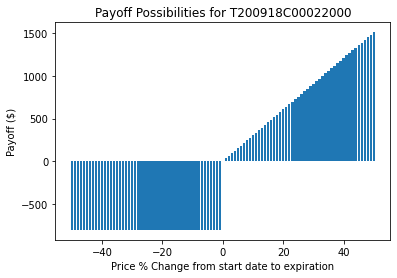

In [8]:
x_axis = np.arange(-50, 51, 1)
payoffs = []
for p in range(len(x_axis)):
    percent = (p - 50)*0.01
    payoff = price_percent_payoff(percent,options_df[options_df.Ticker == 'T'].iloc[5])
    payoffs.append(payoff)

contract = options_df[options_df.Ticker == 'T'].iloc[5]['Contract Name']
plt.bar(x_axis, payoffs)
plt.xlabel('Price % Change from start date to expiration')
plt.ylabel('Payoff ($)')
plt.title('Payoff Possibilities for ' + str(contract));
plt.savefig('T_prices.png', dpi = 800)


In [ ]:
options_df[options_df.Ticker == 'T'].iloc[5]['BE_percent']

-0.0010039880056620376

### Stock Options Evaluation Model: PART II


In [9]:
def delta_dist(ticker, duration, sample_size):
    stock = get_data(ticker).close
    dates = list(stock.index)
    duration = int(duration)
    sample_size = int(sample_size)
    deltas = []

    for s in range(sample_size):
        try:
            x = random.randint(0, (sample_size - 1))
            start = stock[x]
            stop = stock[x + duration]
            difference_percent = (stop - start)/start
            deltas.append(difference_percent)
        except:
            pass

    return deltas


In [10]:
def binned(diffs):
    bins = []
    for bin in range(101):    #needs to be 101 to count -50% and +50%
        begin = (bin - 50)*0.01
        def between_bins(k):
            return (k <= begin + .01) and (k > begin)
        count = list(filter(between_bins, diffs))
        amount = len(count)/len(diffs)  #amount is percent of total
        bins.append(amount)
    return(bins)

In [ ]:
#SAMPLE SIZE 200
changes = delta_dist('AAPL', 14, 200)
binned_changes = binned(changes)
x_axis = np.arange(-50, 51, 1)

plt.bar(x_axis, binned_changes)
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title('AAPL: Probability Distribution- 14 day price change(Sample Size=200)');
plt.savefig('AAPL_prices.png', dpi = 800)


In [ ]:
#SAMPLE SIZE 9000
changes = delta_dist('AAPL', 14, 9000)
binned_changes = binned(changes)
x_axis = np.arange(-50, 51, 1)

plt.bar(x_axis, binned_changes)
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title('AAPL: Probability Distribution- 14 day price change(Sample Size=9000)');
plt.savefig('AAPL_prices.png', dpi = 800)


In [ ]:
#SAMPLE SIZE 3000, DURATION = 5 years
changes = delta_dist('AAPL', 365*3, 3000)
binned_changes = binned(changes)
x_axis = np.arange(-50, 51, 1)

plt.bar(x_axis, binned_changes)
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title('AAPL: Probability Distribution- 3 Year Price Change');
plt.savefig('AAPL_prices.png', dpi = 800)


In [11]:
#Generate time lapse between today and expiration of options contract:
timedate_until_exp = datetime.strptime(expiration, '%B %d, %Y') - datetime.today()
time_until_exp = int(timedate_until_exp.days)  #gives integer value of distance from today until expiration

In [20]:
#Creating dictionary containing each ticker and prob distribution 
scenario_tickers = list(set(options_df.Ticker))
number_of_tickers = len(scenario_tickers)
simulations = 2000

#dict_of_stuff will contain each ticker key corresponding to the 101 values of its distribution of price changes [-50%, 50%]
dict_of_probs = dict()
for stock in scenario_tickers:      #N is the sample size
    try:
        changes = delta_dist(stock, time_until_exp, simulations) 
        distribution_list = binned(changes)   #then, bin these changes so that they fit into the -50% to +50% integer counts
        dict_of_probs.update({stock : distribution_list})  #matches each ticker in dictionary with 101 counts
    except:
        pass 

In [44]:
#Sometimes the dictionary will have issues, in which case we want to filter down options_df to include tickers in dictionary
options_df = options_df[options_df.Ticker.isin(list(dict_of_probs.keys()))]

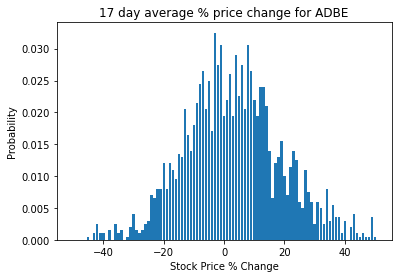

In [24]:
#Verify it works with example
x_axis = np.arange(-50, 51, 1)
example = random.randint(0, number_of_tickers - 1)

plt.bar(x_axis, dict_of_probs[scenario_tickers[example]])
plt.xlabel('Stock Price % Change')
plt.ylabel('Probability')
plt.title(str(time_until_exp) + " day average % price change for " + str(scenario_tickers[example]))
plt.savefig('price_example.png', dpi = 800)

In [45]:
#Generating expected payoffs
x_axis = np.arange(-50, 51, 1)
ExpectedPay = []

for i in range(len(options_df)):
    payoffs = []
    ticker = options_df.iloc[i].Ticker
    for p in range(len(x_axis)):
        percent = (p - 50)*0.01
        payoff = price_percent_payoff(percent, options_df.iloc[i])
        payoffs.append(payoff)
    #payoffs list contains the 101 values to be multiplied by the probabilities 
    probs = dict_of_probs[ticker]
    expected_value = sum( np.array(probs) * np.array(payoffs) )
    ExpectedPay.append(expected_value)

options_df['ExpectedPay'] = ExpectedPay

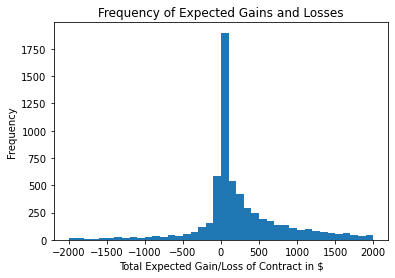

In [46]:
plt.hist(ExpectedPay, bins = 40, range=[-2000, 2000])
plt.xlabel('Total Expected Gain/Loss of Contract in $')
plt.ylabel('Frequency')
plt.title("Frequency of Expected Gains and Losses");
plt.savefig('payoffs.png', dpi = 800)

In [47]:
options_df['ROI'] = options_df.ExpectedPay / options_df.OptionCost
options_df = options_df[options_df.OptionCost > 0]

options_df = options_df[options_df.Volume != '-']
options_df = options_df[options_df['Open Interest'] != '-']

portfolio = options_df[(options_df.ExpectedPay > 0) & (pd.to_numeric(options_df.Volume) > 0) & (pd.to_numeric(options_df['Open Interest']) > 0)]

In [70]:
portfolio.to_csv("options_8_31.csv")